In [2]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pybtex.database.input import bibtex

# Counting
import string
import nltk
from pattern.text.en import singularize, pluralize, lemma
from collections import Counter

In [7]:
# Open a bibtex file
parser = bibtex.Parser()
bibdata = parser.parse_file("mobicom.bib")

# Loop through the individual references
df = None
for bib_id in bibdata.entries:
    b = bibdata.entries[bib_id].fields
    p = bibdata.entries[bib_id].persons
    
    if df is None:
        df = pd.DataFrame(columns=list(b.keys()) + ["author"])
    
    entry = dict(b)
    try:
        b["author"] = ", " .join([" ".join(name.first_names + name.last_names) for name in p["author"]])
        df = df.append(dict(b), ignore_index=True)
    except KeyError:
        continue

df.head()

,title,year,booktitle,location,publisher,address,series,doi,isbn,url,abstract,articleno,numpages,keywords,author,pages
0,Mobile Gaming on Personal Computers with Direc...,2019,The 25th Annual International Conference on Mo...,"Los Cabos, Mexico",Association for Computing Machinery,"New York, NY, USA",MobiCom '19,10.1145/3300061.3300122,9781450361699,https://doi.org/10.1145/3300061.3300122,Playing Android games on Windows x86 PCs has g...,19,15,"x86 windows pc, android emulation, mobile gaming","Qifan Yang, Zhenhua Li, Yunhao Liu, Hai Long, ...",NaN
1,OFDMA-Enabled Wi-Fi Backscatter,2019,The 25th Annual International Conference on Mo...,"Los Cabos, Mexico",Association for Computing Machinery,"New York, NY, USA",MobiCom '19,10.1145/3300061.3300121,9781450361699,https://doi.org/10.1145/3300061.3300121,"In this paper, we for the first time demonstra...",20,15,"ofdma, backscatter, wi-fi","Renjie Zhao, Fengyuan Zhu, Yuda Feng, Siyuan P...",NaN
2,Edge Assisted Real-Time Object Detection for M...,2019,The 25th Annual International Conference on Mo...,"Los Cabos, Mexico",Association for Computing Machinery,"New York, NY, USA",MobiCom '19,10.1145/3300061.3300116,9781450361699,https://doi.org/10.1145/3300061.3300116,Most existing Augmented Reality (AR) and Mixed...,25,16,"convolutional neural network, edge computing, ...","Luyang Liu, Hongyu Li, Marco Gruteser",NaN
3,Device Administrator Use and Abuse in Android:...,2019,The 25th Annual International Conference on Mo...,"Los Cabos, Mexico",Association for Computing Machinery,"New York, NY, USA",MobiCom '19,10.1145/3300061.3345452,9781450361699,https://doi.org/10.1145/3300061.3345452,Device Administrator (DA) capabilities for mob...,51,16,"static analysis, mobile device management, sec...","Zhiyong Shan, Raina Samuel, Iulian Neamtiu",NaN
4,Source Compression with Bounded DNN Perception...,2019,The 25th Annual International Conference on Mo...,"Los Cabos, Mexico",Association for Computing Machinery,"New York, NY, USA",MobiCom '19,10.1145/3300061.3345448,9781450361699,https://doi.org/10.1145/3300061.3345448,IoT and deep learning based computer vision to...,47,16,"neural networks, image compression, mobile edg...","Xiufeng Xie, Kyu-Han Kim",NaN


In [9]:
# Filter out by number of pages.
df["numpages"] = df["numpages"].fillna("0").astype(int)
df = df.drop(df[df["numpages"] < 5].index, axis="index")

df.head()

,title,year,booktitle,location,publisher,address,series,doi,isbn,url,abstract,articleno,numpages,keywords,author,pages
0,Mobile Gaming on Personal Computers with Direc...,2019,The 25th Annual International Conference on Mo...,"Los Cabos, Mexico",Association for Computing Machinery,"New York, NY, USA",MobiCom '19,10.1145/3300061.3300122,9781450361699,https://doi.org/10.1145/3300061.3300122,Playing Android games on Windows x86 PCs has g...,19,15,"x86 windows pc, android emulation, mobile gaming","Qifan Yang, Zhenhua Li, Yunhao Liu, Hai Long, ...",NaN
1,OFDMA-Enabled Wi-Fi Backscatter,2019,The 25th Annual International Conference on Mo...,"Los Cabos, Mexico",Association for Computing Machinery,"New York, NY, USA",MobiCom '19,10.1145/3300061.3300121,9781450361699,https://doi.org/10.1145/3300061.3300121,"In this paper, we for the first time demonstra...",20,15,"ofdma, backscatter, wi-fi","Renjie Zhao, Fengyuan Zhu, Yuda Feng, Siyuan P...",NaN
2,Edge Assisted Real-Time Object Detection for M...,2019,The 25th Annual International Conference on Mo...,"Los Cabos, Mexico",Association for Computing Machinery,"New York, NY, USA",MobiCom '19,10.1145/3300061.3300116,9781450361699,https://doi.org/10.1145/3300061.3300116,Most existing Augmented Reality (AR) and Mixed...,25,16,"convolutional neural network, edge computing, ...","Luyang Liu, Hongyu Li, Marco Gruteser",NaN
3,Device Administrator Use and Abuse in Android:...,2019,The 25th Annual International Conference on Mo...,"Los Cabos, Mexico",Association for Computing Machinery,"New York, NY, USA",MobiCom '19,10.1145/3300061.3345452,9781450361699,https://doi.org/10.1145/3300061.3345452,Device Administrator (DA) capabilities for mob...,51,16,"static analysis, mobile device management, sec...","Zhiyong Shan, Raina Samuel, Iulian Neamtiu",NaN
4,Source Compression with Bounded DNN Perception...,2019,The 25th Annual International Conference on Mo...,"Los Cabos, Mexico",Association for Computing Machinery,"New York, NY, USA",MobiCom '19,10.1145/3300061.3345448,9781450361699,https://doi.org/10.1145/3300061.3345448,IoT and deep learning based computer vision to...,47,16,"neural networks, image compression, mobile edg...","Xiufeng Xie, Kyu-Han Kim",NaN


['Xinyu Zhang', 'Azzedine Boukerche', 'Dimitrios Koutsonikolas', 'Chunyi Peng', 'Jun-Hong Cui', 'Anna Brunstrom', 'Fumin Zhang', 'Feng Qian', 'Songwu Lu', 'Michele Zorzi']


<AxesSubplot:xlabel='author', ylabel='Total publications'>

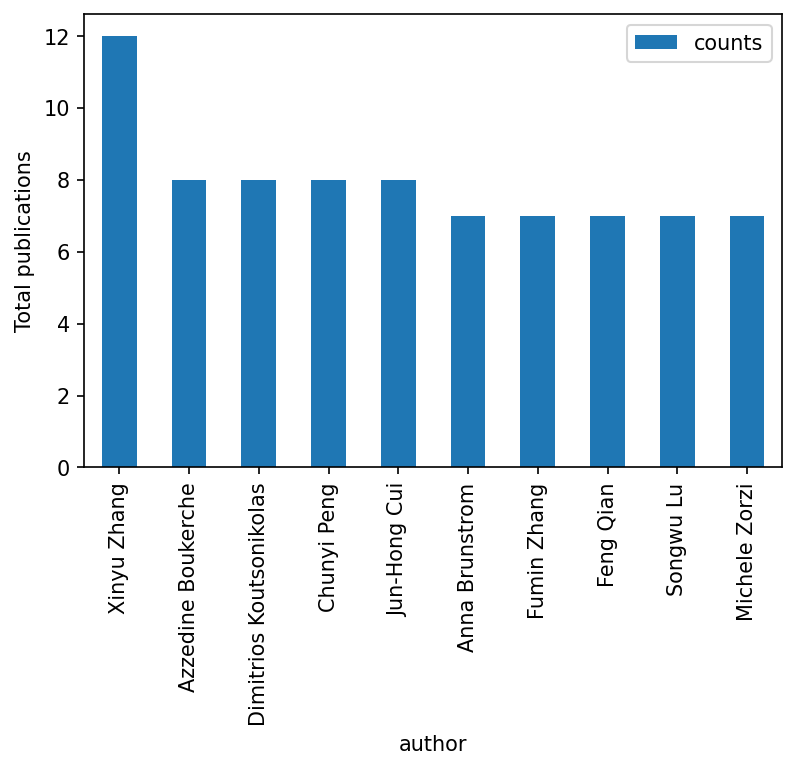

In [10]:
# Count authors in total.
names, counts = np.unique(", ".join(df.author.tolist()).split(", "), return_counts=True)
df_author_counts = pd.DataFrame(
    {
        "author": names,
        "counts": counts
    }
)
df_author_counts = df_author_counts.sort_values(by="counts", ascending=False)

# Get top authors.
top_authors = df_author_counts.head(10).author.tolist()
print(top_authors)

# Plot.
fig, ax = plt.subplots(dpi=150)
ax.set_xlabel("Author")
ax.set_ylabel("Total publications")

df_author_counts.head(10).set_index("author").plot.bar(ax=ax)

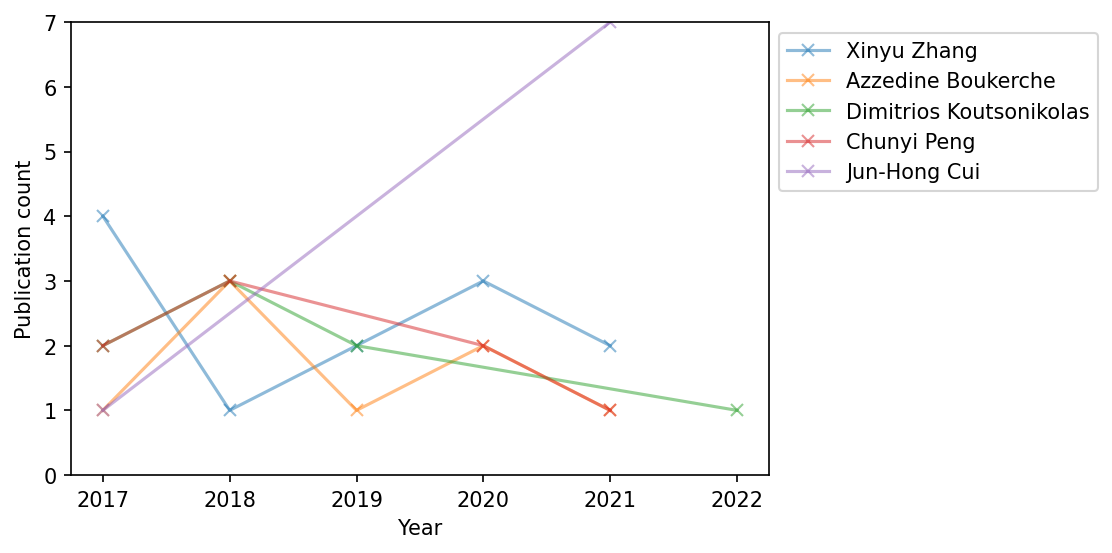

In [11]:
# Get author's publication by year. 
target_authors = top_authors[:5]

# Init plot.
fig, ax = plt.subplots(dpi=150)
ax.set_ylim([0, 7])
ax.set_xlabel("Year")
ax.set_ylabel("Publication count")

for target_author in target_authors:
    df_author = df[df.author.str.contains(target_author)]
    ax.plot(df_author.groupby("year").title.count(), 
            label=target_author, ls="-", marker="x", alpha=0.5)
ax.legend(bbox_to_anchor=(1, 1))

In [14]:
# Keywords analysis.
list_df_keyword_counts = []

for year in np.sort(df.year.unique()):
    
    # Slicing and counting.
    df_year = df[df.year == year].dropna(subset=["keywords"])
    all_year_keywords = ", ".join(df_year.keywords.tolist())
    all_year_keywords = [keyword.strip() for keyword in all_year_keywords.lower().split(",")]
    keywords, counts = np.unique(all_year_keywords, return_counts=True)

    # Make dataframe
    df_keyword_counts = pd.DataFrame(
        {
            "keyword": keywords,
            "keyword_count": counts,
            "year": year
        }
    )
    df_keyword_counts = df_keyword_counts.sort_values(by="keyword_count", ascending=False).head(3)
    
    # Appending.
    list_df_keyword_counts.append(df_keyword_counts)

# Collating.
df_keyword_counts = pd.concat(list_df_keyword_counts)
df_keyword_counts.head(10)

,keyword,keyword_count,year
162,mobility,4,2017
138,lte,4,2017
259,smartphone,3,2017
202,machine learning,6,2018
220,mimo,5,2018
6,5g,5,2018
186,machine learning,5,2019
164,internet of things,5,2019
391,wi-fi,4,2019
153,mmwave,5,2020


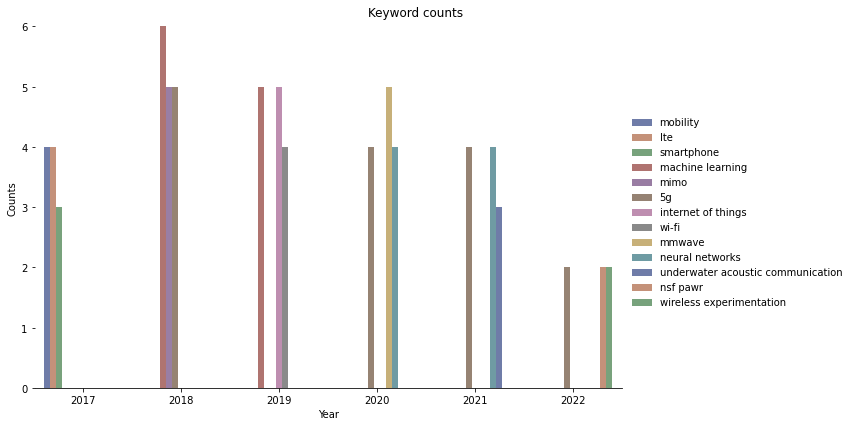

In [18]:
# Draw a nested barplot
g = sns.catplot(aspect=1.5,
    data=df_keyword_counts, kind="bar",
    x="year", y="keyword_count", hue="keyword",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Counts")
g.figure.suptitle("Keyword counts")
g.legend.set_title("")

In [23]:
# Title analysis.
list_df_title_counts = []

for year in np.sort(df.year.unique()):
    
    # Slicing.
    df_year = df[df.year == year].dropna(subset=["title"])

    # Preprocessing.
    combined_text = " ".join(df_year.title).lower()
    # Remove punctuation.
    combined_text.translate(str.maketrans("", "", string.punctuation))
    # Remove prepositions, conjunctions, etc. 
    tokens = nltk.word_tokenize(combined_text)
    tagged = nltk.pos_tag(tokens)
    black_list = ["%", "result",]
    white_list = ["NN", "NNS", "NNP", "NNPS"]
    filtered = list(filter(lambda x: x[1] in white_list, tagged))
    filtered = [token[0] for token in filtered]
    filtered = list(filter(lambda x: x not in black_list, filtered))
    filtered = [singularize(word) for word in filtered]

    # Counting and sorting.
    wordcount = Counter(filtered)
    ser_wordcount = pd.Series(wordcount)
    ser_wordcount = ser_wordcount.sort_values(ascending=False)
    

    # Make dataframe
    df_title_counts = pd.DataFrame(
        {
            "word": ser_wordcount.index,
            "word_count": ser_wordcount.values,
            "year": year
        }
    )
    df_title_counts = df_title_counts.sort_values(by="word_count", ascending=False).head(3)
    
    # Appending.
    list_df_title_counts.append(df_title_counts)

# Collating.
df_title_counts = pd.concat(list_df_title_counts)
df_title_counts.head(10)

,word,word_count,year
0,network,26,2017
1,communication,14,2017
2,datum,10,2017
0,network,32,2018
1,communication,17,2018
2,system,10,2018
0,network,14,2019
1,communication,9,2019
2,protocol,8,2019
0,network,18,2020


Text(0.5, 0.98, 'Title word frequencies')

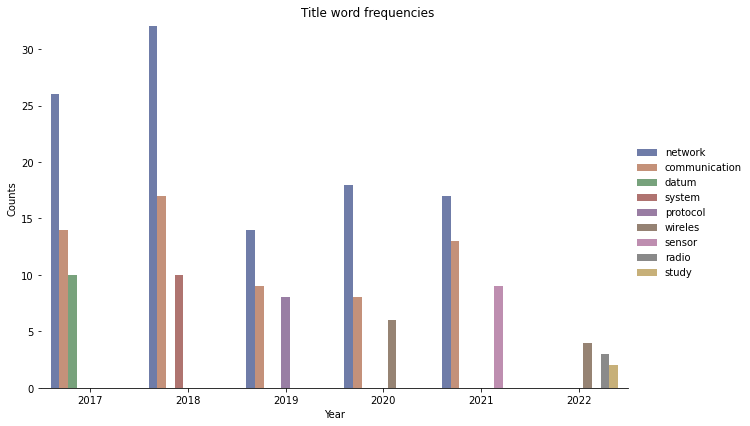

In [24]:
# Draw a nested barplot
g = sns.catplot(aspect=1.5,
    data=df_title_counts, kind="bar",
    x="year", y="word_count", hue="word",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Counts")
g.legend.set_title("")
g.figure.suptitle("Title word frequencies")

In [21]:
# Abstract analysis.
list_df_abstract_counts = []

for year in np.sort(df.year.unique()):
    
    # Slicing.
    df_year = df[df.year == year].dropna(subset=["abstract"])

    # Preprocessing.
    combined_text = " ".join(df_year.abstract).lower()
    # Remove punctuation.
    combined_text.translate(str.maketrans("", "", string.punctuation))
    # Remove prepositions, conjunctions, etc. 
    tokens = nltk.word_tokenize(combined_text)
    tagged = nltk.pos_tag(tokens)
    black_list = ["%", "result",]
    white_list = ["NN", "NNS", "NNP", "NNPS"]
    filtered = list(filter(lambda x: x[1] in white_list, tagged))
    filtered = [token[0] for token in filtered]
    filtered = list(filter(lambda x: x not in black_list, filtered))
    filtered = [singularize(word) for word in filtered]

    # Counting and sorting.
    wordcount = Counter(filtered)
    ser_wordcount = pd.Series(wordcount)
    ser_wordcount = ser_wordcount.sort_values(ascending=False)
    

    # Make dataframe
    df_abstract_counts = pd.DataFrame(
        {
            "word": ser_wordcount.index,
            "word_count": ser_wordcount.values,
            "year": year
        }
    )
    df_abstract_counts = df_abstract_counts.sort_values(by="word_count", ascending=False).head(3)
    
    # Appending.
    list_df_abstract_counts.append(df_abstract_counts)

# Collating.
df_abstract_counts = pd.concat(list_df_abstract_counts)
df_abstract_counts.head(10)

,word,word_count,year
0,network,144,2017
1,datum,78,2017
2,system,73,2017
0,network,147,2018
1,system,104,2018
2,paper,92,2018
0,network,122,2019
1,device,105,2019
2,system,98,2019
0,system,85,2020


Text(0.5, 0.98, 'Abstract word frequencies')

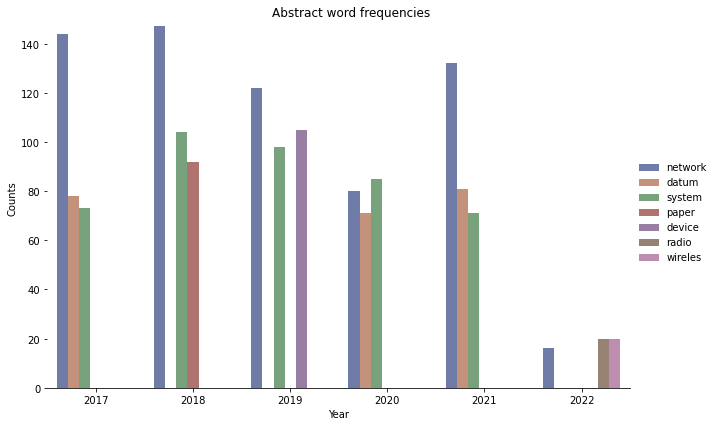

In [22]:
# Draw a nested barplot
g = sns.catplot(aspect=1.5,
    data=df_abstract_counts, kind="bar",
    x="year", y="word_count", hue="word",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Counts")
g.legend.set_title("")
g.figure.suptitle("Abstract word frequencies")